# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для анализа покупателей.
**Цель проекта** — построить модель, которая по фотографии определяет приблизительный возраст человека.

**Задачи:**

* Загрузить и изучить данные (EDA).

* Подготовить изображения для обучения.

* Обучить нейронную сеть для предсказания возраста.

* Оценить качество модели.

* Сделать выводы о применимости модели

# Определение возраста покупателей

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Импортирую необходимые библиотеки

In [2]:
def _load_labels_df(path):
    csv_path = os.path.join(path, 'labels.csv')
    df = pd.read_csv(csv_path)
    df = df.sort_values('file_name').reset_index(drop=True)
    return df


def load_train(path):
    df = _load_labels_df(path)
    split = int(len(df) * 0.75)
    train_df = df.iloc[:split].copy()

    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=True,
        seed=12345
    )
    return generator


def load_test(path):
    df = _load_labels_df(path)
    split = int(len(df) * 0.75)
    test_df = df.iloc[split:].copy()

    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False
    )
    return generator


def create_model(input_shape=(224, 224, 3)):
    backbone = MobileNetV2(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    backbone.trainable = True 

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mse',
        metrics=['mae']
    )
    return model


def train_model(model, train_data, test_data,
                batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    callbacks = [
        EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
    ]

    fit_kwargs = dict(
        x=train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=2
    )

    model.fit(**fit_kwargs)
    return model

Функции

In [3]:
csv_path = '/datasets/faces'
img_path = os.path.join(csv_path, 'final_files')

Константы

## Загрузка данных

In [4]:
df = pd.read_csv('/datasets/faces/labels.csv')
df = df.sort_values('file_name').reset_index(drop=True)

Сохранил csv-файл в переменную

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
df.duplicated().sum()

0

Данные в датасете корректны. Пропуси и дубликаты не обнаружены. Содержание датасета соответствует описанию данных. Названия столбцов оформлены стилистически верно.

## Исследовательский анализ данных

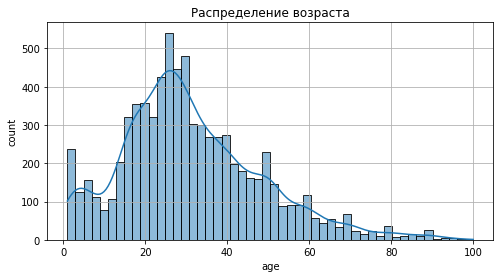

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(data=df,x='real_age',bins=50, kde=True)
plt.title('Распределение возраста')
plt.xlabel('age')
plt.ylabel('count')
plt.grid()
plt.show()

In [9]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

В столбце с возрастом преобладают молодые взрослые: чаще всего встречаются возраста 25–30 лет (пики на 25, 26, 27 и 30), медиана равна 29, при этом дети (1–15 лет) и пожилые (60+) встречаются значительно реже, что создаёт сильный перекос распределения.

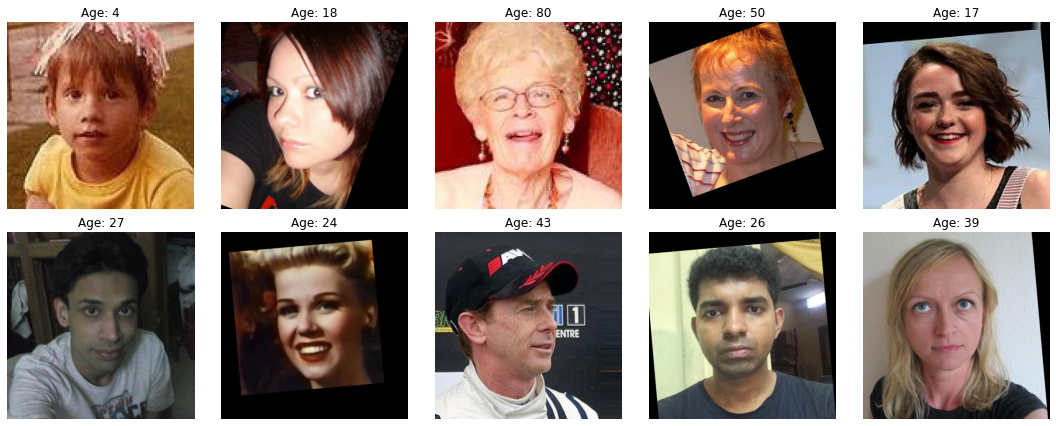

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 10 примеров
for i, ax in enumerate(axes.flat):
    sample = df.iloc[i]
    img = os.path.join(img_path, sample['file_name'])
    image = plt.imread(img)
    ax.imshow(image)
    ax.set_title(f"Age: {sample['real_age']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

На картинках отображаются реальные лица, а указанные в таблице значения возраста соответствуют изображениям.  
Это подтверждает корректность датасета и позволяет использовать его для обучения модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
train_gen = load_train(csv_path)
test_gen = load_test(csv_path)
model = create_model()
history = train_model(model, train_gen, test_gen)
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/20
2025-09-29 18:43:55.524562: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-09-29 18:43:55.965358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 101s - loss: 317.1274 - mae: 13.1655 - val_loss: 230.1683 - val_mae: 12.1220
Epoch 2/20
178/178 - 95s - loss: 119.4758 - mae: 8.4310 - val_loss: 173.8101 - val_mae: 9.9639
Epoch 3/20
178/178 - 94s - loss: 103.7785 - mae: 7.8158 - val_loss: 164.6544 - val_mae: 9.4599
Epoch 4/20
178/178 - 95s - loss: 88.4320 - mae: 7.2373 - val_loss: 136.3927 - val_mae: 8.7662
Epoch 5/20
178/178 - 94s - loss: 81.4593 - mae: 6.8887 - val_loss: 146.2417 - val_mae: 9.1025
Epoch 6/20
178/178 - 94s - loss: 72.4319 - mae: 6.5430 - val_loss: 134.4658 - val_mae: 8.6577
Epoch 7/20
178/178 - 95s - loss: 66.4668 - mae: 6.2718 - val_loss: 139.8725 - val_mae: 8.8858
Epoch 8/20
178/178 - 101s - loss: 64.2652 - mae: 6.0791 - val_loss: 162.4589 - val_mae: 9.3851
Epoch 9/20
178/178 - 101s - loss: 58.1999 - mae: 5.8229 - val_loss: 167.6450 - val_mae: 10.0975
Epoch 10/20
178/178 - 103s - loss: 51.7670 - mae: 5.5010 - val_loss: 128.6725 - val_mae: 8.2389
Epoch 11/20
178/178 - 100s - loss: 48.9588 - mae: 5.4085 - val_loss: 123.9118 - val_mae: 8.0125
Epoch 12/20
178/178 - 101s - loss: 45.8786 - mae: 5.1894 - val_loss: 120.0989 - val_mae: 7.9991
Epoch 13/20
178/178 - 101s - loss: 43.2153 - mae: 5.0656 - val_loss: 136.4464 - val_mae: 8.3071
Epoch 14/20
178/178 - 100s - loss: 43.5833 - mae: 5.0688 - val_loss: 118.1109 - val_mae: 7.8252
Epoch 15/20
178/178 - 101s - loss: 40.3226 - mae: 4.9130 - val_loss: 119.7578 - val_mae: 7.8754
Epoch 16/20
178/178 - 102s - loss: 41.3341 - mae: 4.9434 - val_loss: 124.7614 - val_mae: 8.2292
Epoch 17/20
178/178 - 101s - loss: 39.4783 - mae: 4.8242 - val_loss: 129.4676 - val_mae: 8.1268
Epoch 18/20
178/178 - 101s - loss: 37.4026 - mae: 4.6933 - val_loss: 130.7781 - val_mae: 8.1503
Epoch 19/20
178/178 - 102s - loss: 35.9970 - mae: 4.6122 - val_loss: 120.5840 - val_mae: 7.8890
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 118.1109 - mae: 7.8252

```

## Анализ обученной модели

Модель на базе MobileNetV2 успешно обучилась — на тренировочных данных MAE снизился с ~13 до ~4,6, на валидации метрика улучшилась с 12,1 до 7,8, при этом итоговый MAE на тестовой выборке составил 7,8, что соответствует требованию проекта (MAE ≤ 8) и говорит о том, что модель достаточно хорошо справляется с задачей предсказания возраста, хоть и наблюдается лёгкий разрыв между train и val, указывающий на возможное переобучение.

**Вывод:**

Данные корректны и без пропусков, но распределение возраста сильно смещено в сторону 25–30 лет, что снижает представленность детей и пожилых; модель MobileNetV2 достигла целевого качества (MAE 7.8 на тесте ≤ 8), однако небольшой разрыв между train и val указывает на возможное переобучение, но модель достаточно хорошо обобщает, поэтому рекомендуется использовать техники балансировки и регуляризации для дальнейшего улучшения результата.